# Credit rating system with artificial neural networks

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from keras.optimizers import Adam
import time
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import math

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=UndefinedMetricWarning, module="sklearn.metrics")
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [3]:
data = pd.read_csv("corporate_rating.csv")
data.head()

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,netProfitMargin,pretaxProfitMargin,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnCapitalEmployed,returnOnEquity,assetTurnover,fixedAssetTurnover,debtEquityRatio,debtRatio,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,0.037480,0.049351,0.176631,0.061510,0.041189,0.091514,0.165085,1.098948,5.535506,3.008012,0.750500,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,0.044062,0.048857,0.175715,0.066546,0.053204,0.104800,0.167953,1.207476,6.171983,2.156783,0.683222,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,0.032709,0.044334,0.170843,0.059783,0.032497,0.075955,0.133060,0.993501,4.991711,3.094575,0.755774,0.214529,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,0.020894,-0.012858,0.138059,0.042430,0.025690,-0.027015,0.093279,1.229563,6.017408,2.630950,0.724590,1.816667,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150
4,BBB,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,0.042861,0.053770,0.177720,0.065354,0.046363,0.096945,0.186047,1.081710,5.437795,3.012780,0.750796,0.166966,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790


In [4]:
# defining features and target
features = [
    'currentRatio', 'quickRatio', 'cashRatio', 'daysOfSalesOutstanding',
    'grossProfitMargin', 'operatingProfitMargin', 'pretaxProfitMargin',
    'netProfitMargin', 'effectiveTaxRate', 'returnOnAssets', 'returnOnEquity',
    'returnOnCapitalEmployed', 'debtRatio', 'debtEquityRatio', 'assetTurnover',
    'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare',
    'operatingCashFlowSalesRatio', 'freeCashFlowOperatingCashFlowRatio'
]

target = 'Rating'

# preparing features and target variables
X = data[features]
y = data[target]

# encoding the target variable
y_encoded, y_categories = pd.factorize(y)

# how do the values get encoded?
mapping = {category: code for code, category in enumerate(y_categories)}
print("Mapping of each value in y to its encoded number:")
for category, code in mapping.items():
    print(f"{category}: {code}")

Mapping of each value in y to its encoded number:
A: 0
BBB: 1
AA: 2
BB: 3
B: 4
CCC: 5
D: 6
CC: 7
AAA: 8
C: 9


In [5]:
# frequency of each class
frequency = Counter(y_encoded)
for key, value in frequency.items():
    print(f"Value {key}: Frequency {value}")

Value 0: Frequency 398
Value 1: Frequency 671
Value 2: Frequency 89
Value 3: Frequency 490
Value 4: Frequency 302
Value 5: Frequency 64
Value 6: Frequency 1
Value 7: Frequency 5
Value 8: Frequency 7
Value 9: Frequency 2


In [6]:
# dealing with rare class
rare_class = [6, 9]
rare_class_indices = np.where(np.isin(y_encoded, rare_class))[0]
X_rare = X.iloc[rare_class_indices]
y_rare = y_encoded[rare_class_indices]
X_remaining = X.drop(index = rare_class_indices)
y_remaining = np.delete(y_encoded, rare_class_indices)


# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_remaining, y_remaining, test_size=0.2, random_state=42, stratify=y_remaining)

# adding back rare classes
X_train = np.vstack([X_train, X_rare])
y_train = np.hstack([y_train, y_rare])

X_test = np.vstack([X_test, X_rare])
y_test = np.hstack([y_test, y_rare])

# Normalize/Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# categorizing y sets
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

In [7]:
# model 1: logistic regression with class weights
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight = class_weight_dict)
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)

print("Logistic Regression Classification Report")
print(classification_report(y_test, logistic_predictions))

# printing the frequency of each integer
frequency = Counter(logistic_predictions)
for key, value in frequency.items():
    print(f"Value {key} is predicted {value} times")

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.50      0.14      0.22        80
           1       0.48      0.36      0.41       134
           2       0.11      0.33      0.16        18
           3       0.44      0.29      0.35        98
           4       0.23      0.16      0.19        61
           5       0.14      0.31      0.19        13
           6       0.07      1.00      0.13         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.33      1.00      0.50         2

    accuracy                           0.27       409
   macro avg       0.23      0.36      0.22       409
weighted avg       0.41      0.27      0.30       409

Value 2 is predicted 56 times
Value 1 is predicted 100 times
Value 8 is predicted 58 times
Value 4 is predicted 43 times
Value 7 is predicted 18 times
Value 3 is predicted 63 times
Value 5 is predict

In [8]:
# model 1: logistic regression without class weights
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)

print("Logistic Regression Classification Report")
print(classification_report(y_test, logistic_predictions))

# printing the frequency of each integer
frequency = Counter(logistic_predictions)
for key, value in frequency.items():
    print(f"Value {key} is predicted {value} times")

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.40      0.03      0.05        80
           1       0.37      0.93      0.53       134
           2       0.00      0.00      0.00        18
           3       0.33      0.14      0.20        98
           4       0.35      0.13      0.19        61
           5       0.00      0.00      0.00        13
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2

    accuracy                           0.36       409
   macro avg       0.15      0.12      0.10       409
weighted avg       0.33      0.36      0.26       409

Value 1 is predicted 336 times
Value 3 is predicted 42 times
Value 4 is predicted 23 times
Value 0 is predicted 5 times
Value 7 is predicted 1 times
Value 9 is predicted 1 times
Value 5 is predicted 

In [9]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
#function to create NN models 
def create_model(num_layers=2, num_neurons=10, activation='relu', dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(num_neurons, activation=activation, input_shape=(X_train.shape[1],)))
    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons, activation=activation))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
param_grid = {
    'num_layers': [2, 3],
    'num_neurons': [10, 20, 30],
    'activation': ['relu', 'sigmoid', 'swish', 'leaky_relu'],
    'dropout_rate': [0.0, 0.05, 0.1]
}

In [12]:

best_score = 0
best_params = None
kf = KFold(n_splits=5, shuffle=True, random_state=42)

i = 1

# step 1: finding the best combination of num_layers, num_neurons, and activation
for num_layers in param_grid['num_layers']:
    for num_neurons in param_grid['num_neurons']:
        for activation in param_grid['activation']:
            #print(f"Starting model {i}")
            #print(f"layers: {num_layers}, neurons: {num_neurons}, activation: {activation}")
            i += 1
            start_time = time.time()
            cv_scores = []
            for train_index, val_index in kf.split(X_train):
                X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
                y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
                
                model = create_model(num_layers, num_neurons, activation, dropout_rate=0.0)
                model.fit(X_train_cv, y_train_cv, epochs=20, batch_size=10, verbose=0, class_weight = class_weight_dict)
                val_loss, val_accuracy = model.evaluate(X_val_cv, y_val_cv, verbose=0)
                cv_scores.append(val_accuracy)
            
            mean_cv_score = np.mean(cv_scores)
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_params = {
                    'num_layers': num_layers,
                    'num_neurons': num_neurons,
                    'activation': activation,
                    'dropout_rate': 0.0  # Temporarily set to 0.0
                }
            end_time = time.time()
            elapsed_time = end_time - start_time
            #print(f"Elapsed time: {elapsed_time:.2f} seconds")
            #print("--------------------------------------")

print(f"Best parameters (without dropout): {best_params}")
print(f"Best cross-validation accuracy: {best_score}")

Best parameters (without dropout): {'num_layers': 2, 'num_neurons': 30, 'activation': 'leaky_relu', 'dropout_rate': 0.0}
Best cross-validation accuracy: 0.22367141842842103


In [13]:
# step 2: xxperimenting with different dropout rates using the best combination from step 1
best_dropout_score = 0
best_dropout_params = None

for dropout_rate in param_grid['dropout_rate']:
    #print(f"Testing dropout rate: {dropout_rate}")
    start_time = time.time()
    cv_scores = []
    for train_index, val_index in kf.split(X_train):
        X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
        y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
        
        model = create_model(best_params['num_layers'], best_params['num_neurons'], best_params['activation'], dropout_rate)
        history = model.fit(X_train_cv, y_train_cv, epochs=20, batch_size=10, verbose=0, class_weight = class_weight_dict)
        val_loss, val_accuracy = model.evaluate(X_val_cv, y_val_cv, verbose=0)
        cv_scores.append(val_accuracy)
    
    mean_cv_score = np.mean(cv_scores)
    if mean_cv_score > best_dropout_score:
        best_dropout_score = mean_cv_score
        best_model = model
        best_history = history
        best_dropout_params = {
            'num_layers': best_params['num_layers'],
            'num_neurons': best_params['num_neurons'],
            'activation': best_params['activation'],
            'dropout_rate': dropout_rate
        }
    end_time = time.time()
    elapsed_time = end_time - start_time
    #print(f"Elapsed time: {elapsed_time:.2f} seconds")
    #print("--------------------------------------")

ffnn_loss, ffnn_accuracy = best_model.evaluate(X_test, y_test)

print(f"Best parameters (with dropout): {best_dropout_params}")
print(f"Best cross-validation accuracy: {best_dropout_score}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1973 - loss: 2.2507 
Best parameters (with dropout): {'num_layers': 2, 'num_neurons': 30, 'activation': 'leaky_relu', 'dropout_rate': 0.05}
Best cross-validation accuracy: 0.21507502496242523


In [14]:
history = best_model.fit(X_train, y_train, epochs=20, batch_size=10, verbose=0, validation_split = 0.2, class_weight = class_weight_dict)

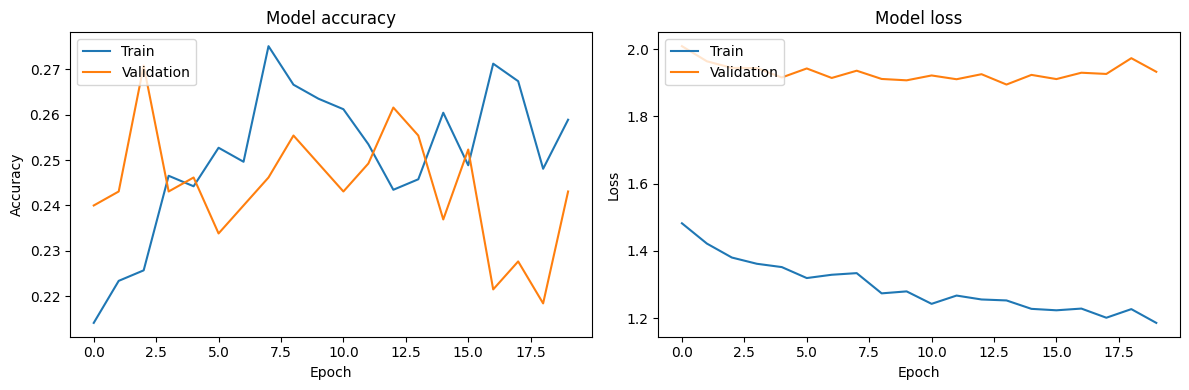

In [15]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
print(f"Best parameters: {best_params}")
print(f"Best CV score: {best_score}")

# Use the best model to predict the test data
ffnn_predictions = best_model.predict(X_test)
ffnn_predictions = np.argmax(ffnn_predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Print the classification report
print("Best FFNN model classification report:")
print(classification_report(y_test_labels, ffnn_predictions))

frequency = Counter(ffnn_predictions)

# Print the frequency of each integer
for key, value in frequency.items():
    print(f"Value {key} is predicted {value} times")

Best parameters: {'num_layers': 2, 'num_neurons': 30, 'activation': 'leaky_relu', 'dropout_rate': 0.0}
Best CV score: 0.22367141842842103
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Best FFNN model classification report:
              precision    recall  f1-score   support

           0       0.27      0.33      0.30        80
           1       0.47      0.28      0.35       134
           2       0.10      0.33      0.15        18
           3       0.50      0.23      0.32        98
           4       0.24      0.16      0.19        61
           5       0.06      0.15      0.09        13
           6       0.00      0.00      0.00         1
           7       0.04      1.00      0.07         1
           8       0.04      1.00      0.07         1
           9       0.00      0.00      0.00         2

    accuracy                           0.26       409
   macro avg       0.17      0.35      0.15       409
weighted avg       0.37      0.26      0.29       409

Value 0 is predicted 96 

In [17]:

# Model 3: Convolutional Neural Network (CNN)
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

cnn_model = Sequential([
    Conv1D(10, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(20, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(50, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(X_train_cnn, y_train, epochs=20, batch_size=10, validation_split=0.2, verbose = 0, class_weight = class_weight_dict)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test)

print(f"Convolutional Neural Network test Accuracy: {cnn_accuracy}")

cnn_predictions = cnn_model.predict(X_test)
cnn_predictions = np.argmax(cnn_predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Print the classification report
print(classification_report(y_test_labels, cnn_predictions))

frequency = Counter(cnn_predictions)

# Print the frequency of each integer
for key, value in frequency.items():
    print(f"Value {key} is predicted {value} times")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1156 - loss: 2.1442 
Convolutional Neural Network test Accuracy: 0.1149144247174263
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.20      0.44      0.27        80
           1       0.50      0.01      0.03       134
           2       0.03      0.11      0.05        18
           3       0.30      0.03      0.06        98
           4       0.17      0.07      0.10        61
           5       0.00      0.00      0.00        13
           6       0.00      0.00      0.00         1
           7       0.02      1.00      0.04         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2

    accuracy                           0.11       409
   macro avg       0.12      0.17      0.05       409
weighted avg       0.30      0.11      0.09       409

Value 0 is predicted 179 times
Value 2 is predicted 60 times
Valu

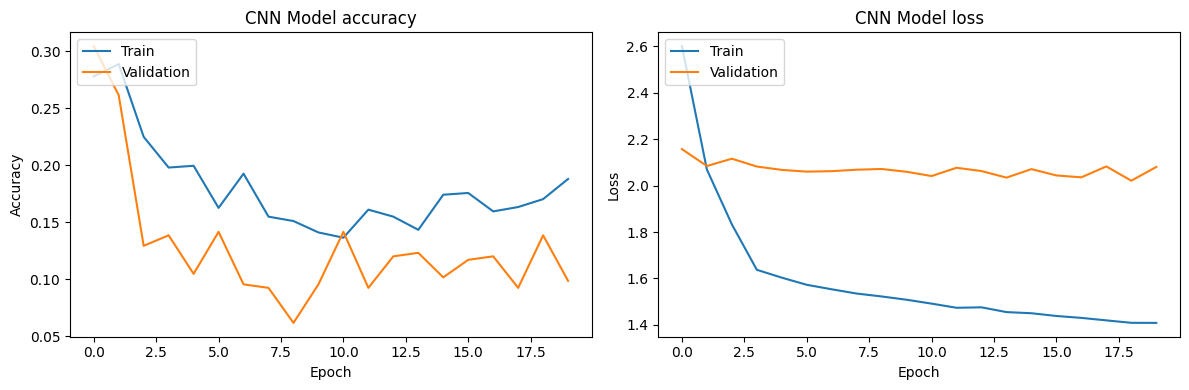

In [18]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [19]:
# Compare performances
print(f"Logistic Regression Accuracy (with class weights): {logistic_accuracy}")
print(f"Feed-Forward Neural Network Accuracy (with class weights): {ffnn_accuracy}")
print(f"Convolutional Neural Network Accuracy (with class weights): {cnn_accuracy}")

Logistic Regression Accuracy (with class weights): 0.36185819070904646
Feed-Forward Neural Network Accuracy (with class weights): 0.21271394193172455
Convolutional Neural Network Accuracy (with class weights): 0.1149144247174263


Conclusion: Due to the dataset imbalance, the models tend to overwhelmingly predict the majority class. This can be fixed by introducing custom class weights - as demonstrated in the logistic regression experiment. When using class weights, the accuracy of the model drops significantly , however precision and recall for minority classes improves a lot. Without class weights, the accuracy of every model hovers around 34-36%, however precision and recall for minority classes is 0 in most cases.

# Volatility forecasting with (recurrent) neural networks

In [20]:
# downloading data

def download_apple_stock_data():
    ticker = 'AAPL'
    data = yf.download(ticker, start="2018-01-01", end="2023-01-01")
    return data[['Open', 'High', 'Low', 'Close']]


In [21]:
# calculating garman-klass volatility

def rolling_garman_klass_volatility(data):
    volatility = []
    for i in range(len(data)):
        day = data.iloc[i]
        log_hl = np.square(np.log(day['High'] / day['Low'])) * 0.5
        log_co = np.square(np.log(day['Close'] / day['Open'])) * (2*np.log(2) - 1)
        vol = np.sqrt(log_hl - log_co)
        volatility.append(vol)
    return volatility 


In [22]:
# function for creating models

def build_model(model_type, input_shape, layers, neurons_per_layer, activation='sigmoid', optimizer='adam', loss='mse'):
    model = Sequential()
    for i in range(layers):
        if model_type.lower() == 'rnn':
            if i == 0:
                model.add(SimpleRNN(neurons_per_layer, activation=activation, input_shape=input_shape, return_sequences=(i < layers-1)))
            else:
                model.add(SimpleRNN(neurons_per_layer, activation=activation, return_sequences=(i < layers-1)))
        elif model_type.lower() == 'gru':
            if i == 0:
                model.add(GRU(neurons_per_layer, activation=activation, input_shape=input_shape, return_sequences=(i < layers-1)))
            else:
                model.add(GRU(neurons_per_layer, activation=activation, return_sequences=(i < layers-1)))
        elif model_type.lower() == 'lstm':
            if i == 0:
                model.add(LSTM(neurons_per_layer, activation=activation, input_shape=input_shape, return_sequences=(i < layers-1)))
            else:
                model.add(LSTM(neurons_per_layer, activation=activation, return_sequences=(i < layers-1)))
        else:
            raise ValueError("Invalid model type. Choose from 'rnn', 'gru', or 'lstm'")
    
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss)
    return model


In [23]:
# preprocessing time-series data

def preprocess_time_series(data, sequence_length):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length+1])
    
    sequences = np.array(sequences)
    X = sequences[:, :-1]
    y = sequences[:, -1]
    
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.2)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler


In [24]:
# grid search best parameters

def grid_search_model(model_type, X_train, y_train, X_val, y_val, param_grid):
    best_params = None
    best_score = float('inf')
    
    for params in ParameterGrid(param_grid):
        params['model_type'] = model_type
        model = build_model(**params)
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        val_loss = model.evaluate(X_val, y_val, verbose=0)
        
        if val_loss < best_score:
            best_score = val_loss
            best_params = params
            best_model = model
            best_history = history
    
    return best_model, best_params, best_history

In [25]:
# evaluating models

def evaluate_models(models, test_set, scaler):
    X_test, y_test = test_set
    results = []
    
    for model, model_name in models:
        test_loss = model.evaluate(X_test, y_test, verbose=0)
        results.append((model_name, test_loss))
    
    for name, loss in results:
        print(f"Model: {name}, Test Loss: {loss}")
    
    # Visualize predictions vs reality
    plt.figure(figsize=(15, 5))
    for model, model_name in models:
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(predictions)
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
        
        plt.plot(y_test_actual, label='Actual volatility')
        plt.plot(predictions, label=f'Predicted volatility ({model_name})')
        plt.title(f'Actual vs Predicted volatility for {model_name}')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

In [26]:
def evaluate_models(models, test_set, scaler):
    X_test, y_test = test_set
    results = []
    
    for model, model_name in models:
        test_loss = model.evaluate(X_test, y_test, verbose=0)
        results.append((model_name, test_loss))
    
    for name, loss in results:
        print(f"Model: {name}, Test Loss: {loss}")
    
    # Visualize predictions vs reality
    plt.figure(figsize=(15, 5))
    
    # Inverse transform y_test_actual only once
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    plt.plot(y_test_actual, 'r--', linewidth=2, label='Actual volatility')  # Thick red dotted line for actual values

    # Plot predictions for each model
    for model, model_name in models:
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(predictions)
        plt.plot(predictions, label=f'Predicted volatility ({model_name})')

    
    plt.title('Actual vs Predicted volatility')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

[*********************100%%**********************]  1 of 1 completed
Model: rnn, Test Loss: 0.005921788513660431
Model: gru, Test Loss: 0.005399116314947605
Model: lstm, Test Loss: 0.0052368976175785065
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/stepWARNING:tensorflow:6 out of the last 21 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000016C683A9300> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more det

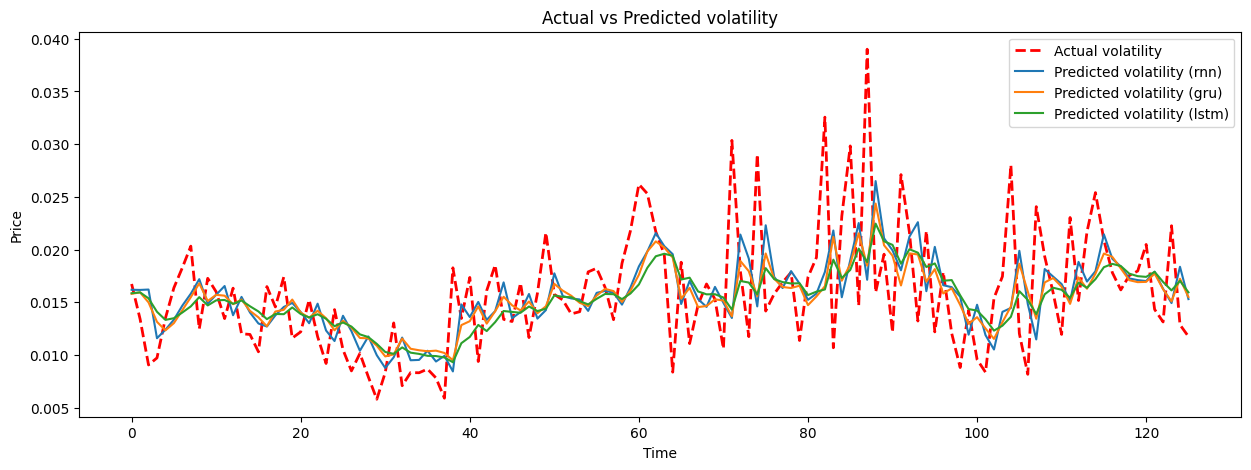

In [27]:
if __name__ == "__main__":
    # Download the data
    data = download_apple_stock_data()
    
    # Calculate volatility and preprocess data
    vol_data = rolling_garman_klass_volatility(data)
    sequence_length = 10
    X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess_time_series(vol_data, sequence_length)
    
    # Define parameter grid
    model_types = ['rnn', 'gru', 'lstm']
    results = {}

    param_grid = {
        'input_shape': [(sequence_length, 1)],
        'layers': [1, 2],
        'neurons_per_layer': [20, 40, 60],
        'activation': ['sigmoid', "relu"],
        'optimizer': ['adam'],
        'loss': ['mse']
    }
    
    results = {
        key: {"best_model": None, "best_params": None, "best_history": None}
        for key in model_types
    }

    # Grid search for each model type
    for model_type in model_types:
        result = grid_search_model(model_type, X_train, y_train, X_val, y_val, param_grid)
        results[model_type]["best_model"] = result[0]
        results[model_type]["best_params"] = result[1]
        results[model_type]["best_history"] = result[2]
    
    models = [(value['best_model'], key) for key, value in results.items()]

    # Evaluate and visualize models
    evaluate_models(models, (X_test, y_test), scaler)


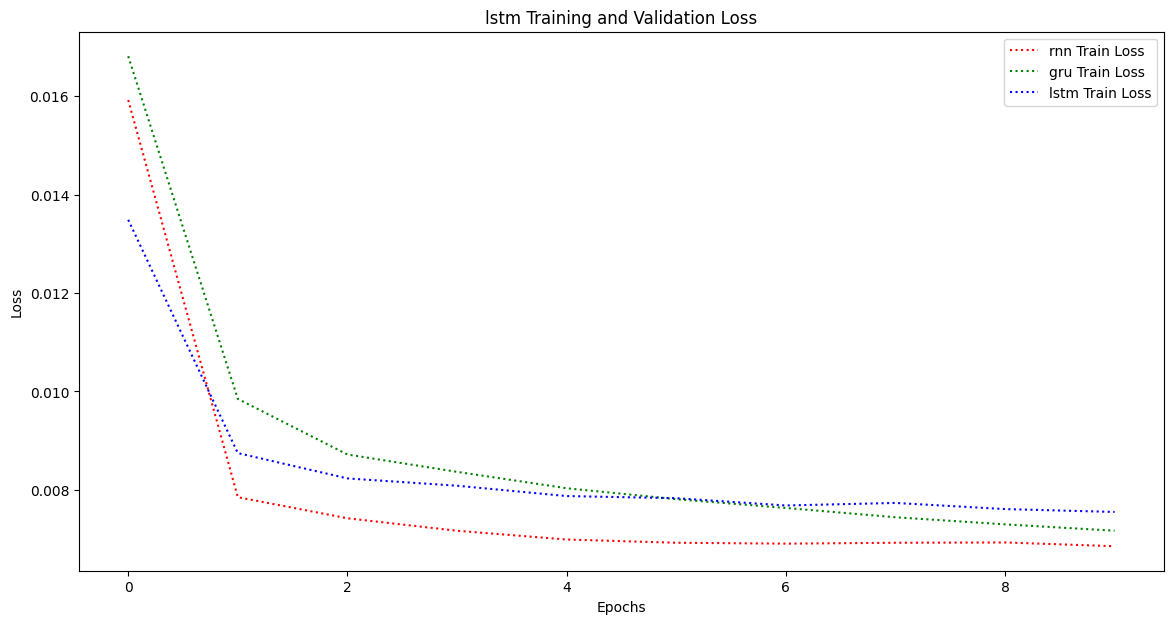

In [28]:
colors = {'rnn': 'red', 'lstm': 'blue', 'gru': 'green'}

plt.figure(figsize=(14, 7))

for model in model_types:
    plt.plot(results[model]["best_history"].history["loss"], label=f'{model} Train Loss', color=colors[model], linestyle='dotted')
    #plt.plot(results[model]["best_history"].history["val_loss"], label=f'{model} Validation Loss', color=colors[model_type])
    plt.title(f'{model} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

In [30]:
# finding best p

best_overall_model = results["gru"]["best_model"]

mse_results = {}
for sequence_length in (range(10, 60, 10)):
    X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess_time_series(vol_data, sequence_length)

    model = results["gru"]["best_model"]

    model.fit(X_train, y_train, epochs=20, batch_size=10, validation_data=(X_val, y_val), verbose=0)
    y_val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    mse_results[sequence_length] = mse
    
optimal_sequence_length = min(mse_results, key=mse_results.get)

# reprocessing the data with the optimal sequence length
X_train_opt, y_train_opt, X_val_opt, y_val_opt, X_test_opt, y_test_opt, scaler_opt = preprocess_time_series(vol_data, optimal_sequence_length)

# training the model again using the optimal sequence length
best_overall_model.fit(X_train_opt, y_train_opt, epochs=10, batch_size=32, validation_data=(X_val_opt, y_val_opt), verbose=0)
y_test_pred = best_overall_model.predict(X_test_opt)
test_mse = mean_squared_error(y_test_opt, y_test_pred)

print(f"Optimal p: {optimal_sequence_length}")
print(f"Test set MSE: {test_mse}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Optimal p: 20
Test set MSE: 0.006056412576258413
